# Hierarchical Cell Data with Relative and Absolute Time

This notebook demonstrates how to use `DimensionInterval` to model hierarchical experimental data where:

- **Cells** are recorded sequentially, each with their own time window
- **Relative time** starts at 0 for each cell (local to the cell)
- **Absolute time** is the global experimental time
- Each cell has associated spectral data (e.g., wavenumber measurements)

This is common in experiments where you record from multiple cells/trials sequentially, and want to align data both within-cell (relative) and across the experiment (absolute).


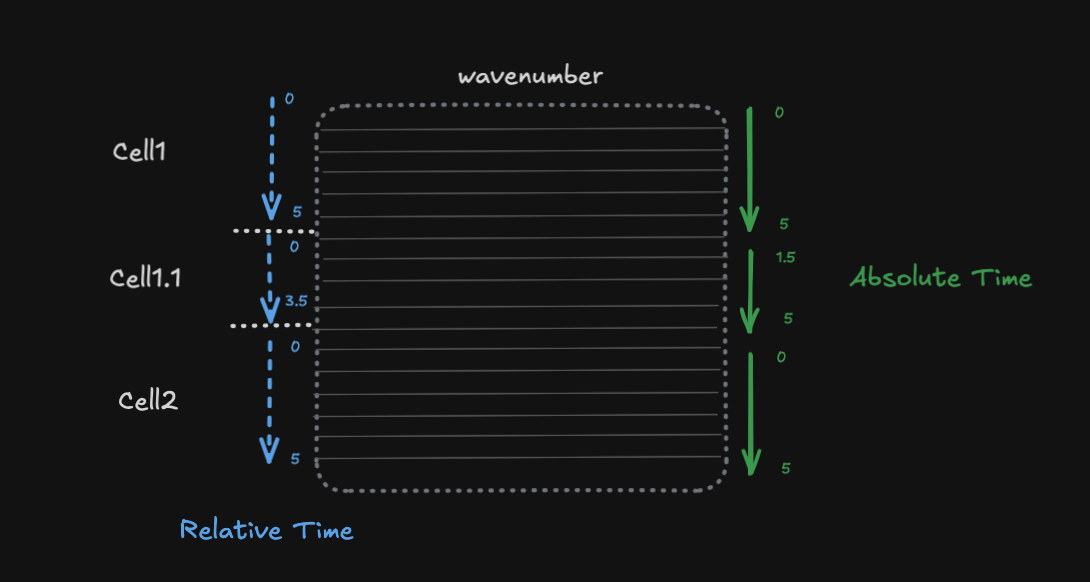

In [ ]:
import numpy as np
import xarray as xr
from linked_indices import DimensionInterval

## Creating the cell hierarchy

We have three cells recorded at different absolute times:

| Cell    | Absolute Time | Relative Time | Duration |
|---------|---------------|---------------|----------|
| Cell1   | 0 - 5         | 0 - 5         | 5s       |
| Cell1.1 | 5 - 10        | 0 - 5 (reset) | 5s (3.5s active) |
| Cell2   | 10 - 15       | 0 - 5 (reset) | 5s       |

In [ ]:
# Cell definitions with absolute timing
cells = ["Cell1", "Cell1.1", "Cell2"]
cell_abs_onset = np.array([0.0, 5.0, 10.0])  # Absolute start time
cell_duration = np.array([5.0, 5.0, 5.0])  # Duration of each cell recording

# Spectral dimension (wavenumber) - typical spontaneous Raman range
wavenumbers = np.linspace(400, 3400, 1340)  # 400-3400 cm⁻¹, 1340 points

## Building the absolute time axis

The absolute time runs continuously across the entire experiment (0 to 15 seconds):

In [ ]:
# Absolute time axis - continuous across all cells
dt = 0.1  # 100ms resolution
abs_time = np.arange(0, 15, dt)  # 0 to 15 seconds

# Generate synthetic spectral data (wavenumber x absolute_time)
np.random.seed(42)
spectral_data = np.random.randn(len(wavenumbers), len(abs_time))

# Add some structure - different cells have different spectral signatures
for i, (onset, dur) in enumerate(zip(cell_abs_onset, cell_duration)):
    mask = (abs_time >= onset) & (abs_time < onset + dur)
    spectral_data[:, mask] += (i + 1) * 0.5  # Different baseline per cell

## Creating the Dataset with DimensionInterval

We create a dataset where:
- `abs_time` is the continuous time dimension
- `cell` dimension is linked to `abs_time` via onset/duration intervals
- `wavenumber` is an independent spectral dimension

In [ ]:
# Create the dataset
ds = xr.Dataset(
    {"spectra": (("wavenumber", "abs_time"), spectral_data)},
    coords={
        # Continuous absolute time
        "abs_time": abs_time,
        # Spectral dimension
        "wavenumber": wavenumbers,
        # Cell dimension with onset/duration
        "cell": ("cell", cells),
        "cell_onset": ("cell", cell_abs_onset),
        "cell_duration": ("cell", cell_duration),
    },
)
ds

In [ ]:
# Apply DimensionInterval to link abs_time and cell dimensions
ds = ds.drop_indexes(["abs_time", "cell"]).set_xindex(
    ["abs_time", "cell_onset", "cell_duration", "cell"],
    DimensionInterval,
    onset_duration_coords={"cell": ("cell_onset", "cell_duration")},
)
ds

## Selecting by cell

When we select a cell, the absolute time is automatically constrained to that cell's interval:

In [ ]:
# Select Cell1 - abs_time is constrained to [0, 5)
ds.sel(cell="Cell1")

In [ ]:
# Select Cell1.1 - abs_time is constrained to [5, 10)
ds.sel(cell="Cell1.1")

## Selecting by absolute time

Selecting a time range automatically constrains which cells are included:

In [ ]:
# Select time range that spans Cell1 and Cell1.1
ds.sel(abs_time=slice(3, 7))

## Adding relative time

For within-cell analysis, we often want **relative time** that starts at 0 for each cell. We can compute this as a derived coordinate:

In [ ]:
def add_relative_time(ds_cell):
    """Add relative time coordinate (time since cell onset)."""
    # Get the cell's onset time
    onset = ds_cell.cell_onset.values.item()
    # Compute relative time
    rel_time = ds_cell.abs_time.values - onset
    return ds_cell.assign_coords(rel_time=("abs_time", rel_time))


# Example: Cell1 with relative time
cell1 = add_relative_time(ds.sel(cell="Cell1"))
cell1

In [ ]:
# Cell1.1 with relative time - starts at 0 even though abs_time starts at 5
cell1_1 = add_relative_time(ds.sel(cell="Cell1.1"))
cell1_1.rel_time.values[:10]  # First 10 relative time points

## Stacking cells with relative time

A common analysis pattern is to align all cells by their relative time for comparison. Since each cell has the same duration, we can create a stacked view:

In [ ]:
# Create a common relative time axis for stacking
rel_time_common = np.arange(0, 5, dt)


def extract_cell_data(ds, cell_name, rel_time_axis):
    """Extract a single cell's data aligned to a common relative time axis."""
    cell_data = ds.sel(cell=cell_name)
    onset = cell_data.cell_onset.values.item()

    # Get absolute times that correspond to the relative time axis
    abs_times_needed = rel_time_axis + onset

    # Select data at these times (using nearest neighbor for any boundary issues)
    selected = cell_data.sel(abs_time=abs_times_needed, method="nearest")

    return xr.Dataset(
        {"spectra": (("wavenumber", "rel_time"), selected.spectra.values)},
        coords={
            "wavenumber": selected.wavenumber.values,
            "rel_time": rel_time_axis,
        },
    )


# Extract each cell with common relative time axis
cell_datasets = [extract_cell_data(ds, cell, rel_time_common) for cell in cells]

# Stack along cell dimension
stacked = xr.concat(cell_datasets, dim=xr.Variable("cell", cells))
stacked

Now we can easily compare cells at the same relative time point:

In [ ]:
# Compare all cells at relative time = 2.5 seconds
stacked.sel(rel_time=2.5, method="nearest")

In [ ]:
# Average spectrum across all cells at each relative time point
stacked.spectra.mean(dim="cell")

## Summary

This example demonstrated:

1. **Hierarchical cell structure** - Cells recorded at different absolute times
2. **DimensionInterval linking** - Absolute time automatically constrained when selecting cells
3. **Relative time computation** - Converting from absolute to within-cell relative time
4. **Stacked analysis** - Aligning cells by relative time for cross-cell comparison

The key insight is that `DimensionInterval` handles the absolute time ↔ cell relationship, while relative time can be computed on-the-fly or stored as an additional coordinate for within-cell analysis.